In [1]:
import sys
sys.path.append('/Users/mariana/Documents/projects/Graphs/egnn')
sys.path.append('/Users/mariana/Documents/projects/Graphs/DiGress/src/analysis/')
sys.path.append('/Users/mariana/Documents/projects/Graphs/DiGress/')
sys.path.append('/opt/homebrew/lib/python3.11/site-packages')

In [2]:
import graph_tool.all as gt

In [31]:
from spectre_utils import spectral_stats, orbit_stats_all, clustering_stats, eval_acc_sbm_graph, degree_stats

In [4]:
from ae_datasets import d_selector, Dataloader
from ae_datasets.d_creator import max_n_nodes, DatasetCommunity, DatasetErdosRenyiNodes
import graph as gl
from losess import vae_loss
import eval

In [5]:
import networkx as nx

In [6]:
import torch

In [7]:
import numpy as np
from torch.nn import functional as F

In [8]:
import matplotlib.pyplot as plt

In [9]:
import yaml
import json
import os
import models
from torch import nn

In [10]:
def torch_adj_bce(pred, gt, reduce='mean', weight=None):
    return F.binary_cross_entropy(pred.view(-1, 1), gt.view(-1, 1), reduction=reduce, weight=weight)

In [11]:
# Load model
root_pth = '/Users/mariana/Documents/projects/Graphs/EGNN_VAE/nodes_100_5comm/seed_1_K10/'
# root_pth = '/Users/mariana/Documents/projects/Graphs/EGNN_VAE/nodes_10_erdos/probando'

config = yaml.load(open(os.path.join(root_pth, 'config.yaml'), 'r'), Loader=yaml.FullLoader)
device = 'cpu'

plots = config.get('plots', 0)
exp_name = config.get('exp_name', 'exp_1')
seed = config.get('seed', 1)
outf = config.get('outf', 'outputs_ae')

train = config['train']
epochs = train.get('epochs', 100)
no_cuda = train.get('no-cuda', 0)
log_interval = train.get('log_interval', 100)
test_interval = train.get('test_interval', 2)
generate_interval = train.get('generate-interval', 100)
lr = float(train.get('lr', 1e-4))

data = config['data']
dataset_name = data.get('dataset', 'community_ours')
with_pos = data.get('with_pos', 1)
n_nodes = data.get('n_nodes', 10)
n_communities = data.get('n_communities', 2)
  
model_dict = config['model']
model = model_dict.get('model', 'ae_egnn')
nf = model_dict.get('nf', 64)
emb_nf = model_dict.get('emb_nf', 8)
K = model_dict.get('K', 2)
attention = model_dict.get('attention', 0)
noise_dim = model_dict.get('noise_dim', 0)
n_layers = model_dict.get('n_layers', 4)
reg = float(model_dict.get('reg', 1e-3))
clamp = model_dict.get('clamp', 1)
weight_decay = float(model_dict.get('weight_decay', 1e-16))

In [12]:
model_dict.get('K')

10

In [13]:
# dataset = d_selector.retrieve_dataset(dataset_name, K=K, with_pos=with_pos, 
#                                       n_nodes=n_nodes, directed=True,
#                                       num_communities=n_communities)

In [14]:
dataset = d_selector.retrieve_dataset(dataset_name, with_pos=with_pos, K=K, partition="test", directed=True, 
                                      n_nodes=n_nodes, num_communities=n_communities)
test_loader = Dataloader(dataset, batch_size=1, shuffle=False)

Creating dataset with  5  communities


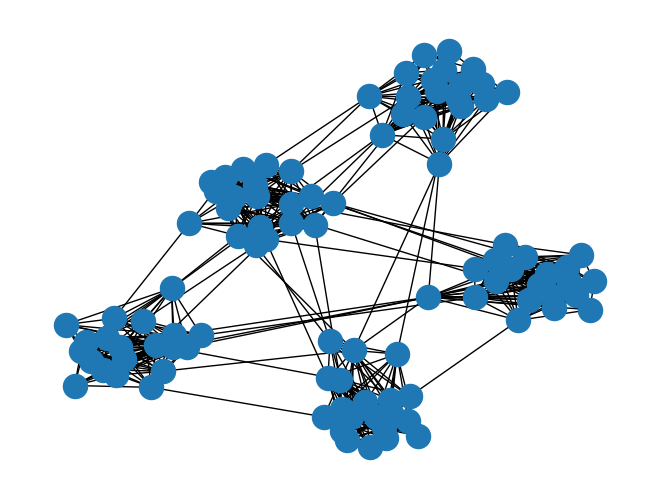

In [15]:
gl.plot_graph(dataset.graphs[122])

In [16]:
model_pth = os.path.join(root_pth, 'model.pt')
model = models.AE_EGNN(hidden_nf=nf, K=K, act_fn=nn.SiLU(), device=device, n_layers=n_layers,
                       reg=reg, clamp=clamp)

state_dict = torch.load(model_pth, map_location=device)
model.load_state_dict(state_dict)

model.eval()
rec = []
gt = []

test_bces = []
adj_errs = []

with torch.no_grad():
    for idx, data in enumerate(test_loader):
        graph = data[0]
        n_nodes = graph.get_num_nodes()

        if with_pos:
            coords = graph.get_coords()
            coords = coords.to(device)
        else:
            coords = None

        nodes, edges, edge_attr, adj_gt = graph.get_dense_graph(store=True, loops=False)
        nodes, edges, edge_attr, adj_gt = nodes.to(device), [edges[0].to(device), edges[1].to(device)], edge_attr.to(device), adj_gt.to(device)

        adj_pred, mu = model(nodes, edges, coords, edge_attr)
        
        rec.append(adj_pred)
        gt.append(adj_gt)
        
        bce = torch_adj_bce(adj_pred, adj_gt)
        _, adj_err = eval.adjacency_error(adj_pred, adj_gt)
        
        test_bces.append(bce)
        adj_errs.append(adj_err)

In [17]:
preds = []
for adj in rec:
    adj = (adj > 0.5).type(torch.int32)
    preds.append(adj.numpy())

In [18]:
gts = []
for adj in gt:
    gts.append(adj.numpy())

In [19]:
g_preds = []
g_gts = []

for adj_pred, adj_gt in zip(preds, gts):
    g_preds.append(nx.from_numpy_array(adj_pred))
    g_gts.append(nx.from_numpy_array(adj_gt))


In [34]:
sstats = spectral_stats(g_gts, g_preds, is_parallel=False)

In [35]:
sstats

0.024796704942735337

In [36]:
spectral_stats(g_gts, g_gts, is_parallel=False)

0.0

In [23]:
# orbit = orbit_stats_all(g_gts, g_preds)

In [26]:
 clustering = clustering_stats(g_gts, g_preds, bins=100, is_parallel=False,
                                          compute_emd=False)

In [27]:
clustering

0.007460752805451188

In [29]:
eval_acc_sbm_graph(g_preds, refinement_steps=100, strict=True)

0.002

In [32]:
degree_stats(g_gts, g_preds, is_parallel=False, compute_emd=False)

0.009351700996422352